# analysis of primary culture mouse neuron

In [13]:
from utilities import *
import seaborn as sns

### downloading files from zenodo

https://zenodo.org/records/16037033

there are three examples

 - ferret Apical Radial Glia endfoot
 - mouse primary culture neuron
 - ferret cortex neuron

 code is based on primary culture neurons

 but the other files are available to try the analysis


the download might require a few minutes
 - ferret Apical Radial Glia endfoot
 - pc_neuron:   around 15 minutes
 - ferret cortex neuron

In [ ]:
pic_names = ['fe_endfoot', 'pc_neuron', 'fe_neuron']

pic_name = pic_names[1]                 # 'pc_neuron'

path_name = get_zenodo(pic_name)

## reading the images

- GFP: to obtain the pixel resolution

- CELL: binary mask of the segmented cell (or cells)

- SOMA: binary mask of the segmented soma

resolution: (0.035320000974832025, 0.035320000974832025, 0.159452)


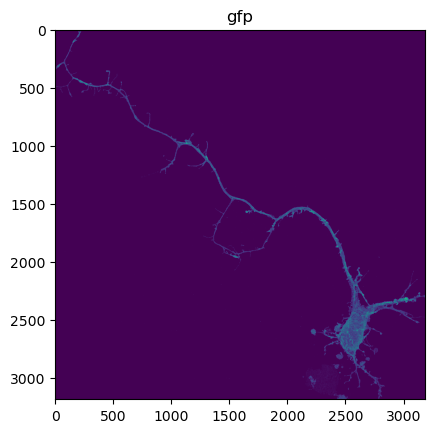

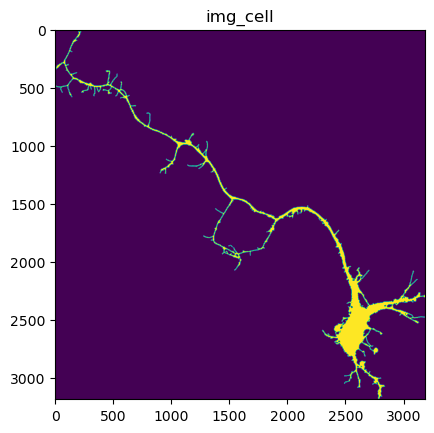

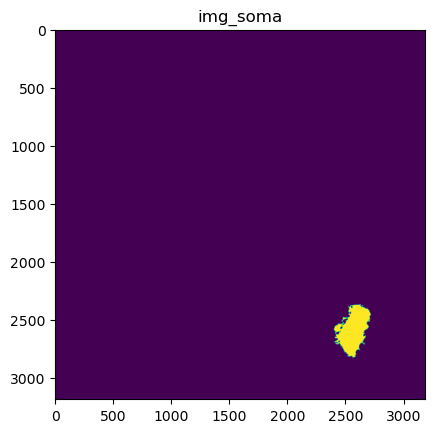

In [15]:
path_name = 'C:/Users/USUARIO/Documents/github/mito_pics2/directory'


pic_name = 'pc_neuron'


img_gfp, res = get_picture(path_name + f'/{pic_name}_GFP.tif')
print(f'resolution: {res}')
show_pic(img_gfp, 'gfp')

shape_0 = img_gfp.shape

img_cell, _ = get_picture(path_name + f'/{pic_name}_CELL.tif')

info_cell = get_masks(img_cell)

# labels of the cells
cell_labels = info_cell[0]
# array with cell masks
cell_masks = info_cell[2]
show_pic(img_cell, 'img_cell')

img_soma = get_picture(path_name + f'/{pic_name}_SOMA.tif')[0]
show_pic(img_soma, 'img_soma')

# let's focus on the only cell
cell_label = cell_labels[0]
cell_mask = cell_masks[0]

soma_mask = img_soma.astype(bool)

## process identification

all the connected components outside the nucleus are separated and annotated with their own label

the defualt minimum length is 2 $\mu m$, it can be changed with the parameter `threshold = ...`

the background value is 0

In [ ]:
compartment_annotation, _ = cell_annotation(cell_mask, soma_mask)

print(f'compartment labels: {np.unique(compartment_annotation)[1:]}')
show_pic(compartment_annotation, palette = 'magma', show_legend=True)

# tifffile.imwrite(f'{path_name}/pc_neuron_compartments.tif', max_proj(compartment_annotation))

## analysis of the branching structure

the network representing the processes is split into linear component with the same Strahler number

`branching_df` contains a row for each linear strahler component (which has a unique id `strahler_id`), his length and which cellular compartment it belongs to

(the analysis might require a few minutes)

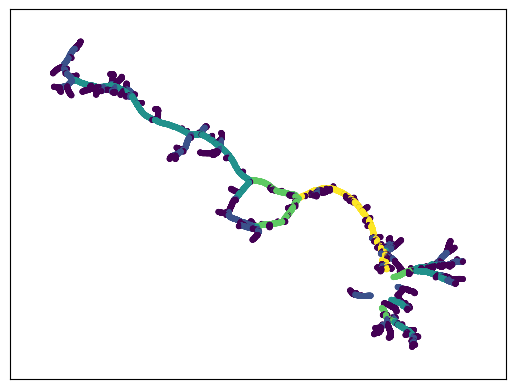

1: 289
2: 55
3: 10
4: 4
5: 1


In [ ]:
branching_df, annotated_G = strahler_analysis(cell_mask, soma_mask, res, compartment_annotation, show = True)

In [ ]:
print(branching_df)

     strahler_id  strahler_number     length  compartment
0              1                1   1.526546            5
1              2                1   0.538691            4
2              3                1   0.114146            8
3              4                1   0.564816            2
4              5                1   3.738892            2
..           ...              ...        ...          ...
354          355                4  16.872654            2
355          356                4  14.688270            2
356          357                4   4.488839            8
357          358                4   3.709873            4
358          359                5  43.457825            2

[359 rows x 4 columns]


### number of segments for Strahler number

[158  31   5   2   1]


<Axes: xlabel='strahler_number'>

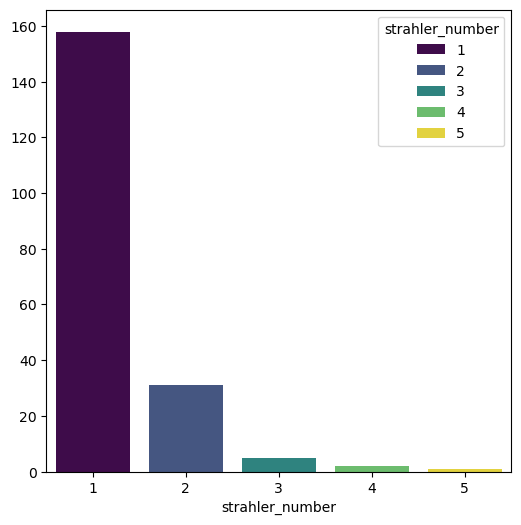

In [ ]:
branch2_df = branching_df[branching_df['compartment'] == 2]

print(branch2_df['strahler_number'].value_counts().values)

plt.figure(figsize=(6, 6))

sns.barplot(
    y = branch2_df['strahler_number'].value_counts().values,
    x = branch2_df['strahler_number'].value_counts().index,
    hue = branch2_df['strahler_number'].value_counts().index,
    palette = 'viridis'
)

#### length of semgents

<Axes: xlabel='strahler_number', ylabel='length'>

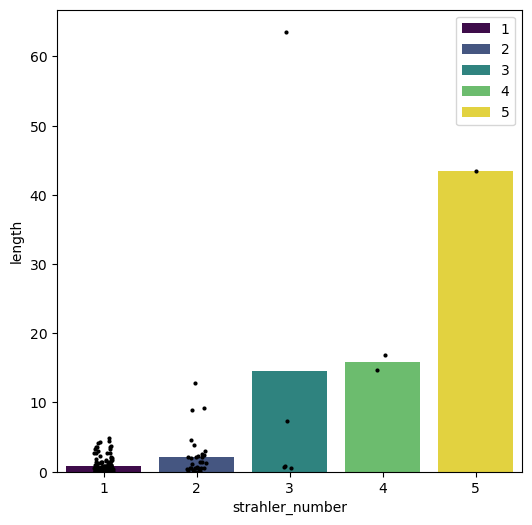

In [ ]:
plt.figure(figsize=(6, 6))

sns.barplot(
    data = branch2_df,
    y = 'length',
    x = 'strahler_number',
    hue = 'strahler_number',
    palette = 'viridis',
    errorbar = None
)

sns.stripplot(
    data = branch2_df,
    y = 'length',
    x = 'strahler_number',
    color = 'black',
    jitter=True,
    size=3,
)

#### annotation of the map

(requires around 30 min for pc_neuron)

In [ ]:
annotated_map = annotate_from_network(cell_mask, soma_mask, annotated_G, l='strahler_id')

show_pic(annotated_map)

## mitochondria analysis

this must be performed for pc_neuron (the other samples don't have mitochondria segmentation)

In [ ]:
img_mito = read_h5(path_name + '/pc_neuron_MITOBIN.h5')
mito_bin = img_mito.astype(bool)

soma_dist = geodesic_dist(cell_mask, soma_mask, res)

# cell analysis
cell_tables = cell_analysis(mito_bin, annotated_map, soma_dist, res)

# aggregated results on compartments
results_cell = cell_tables[0]
# mitochondria table
results_mito_cell = cell_tables[1]

print(results_cell)
print(results_mito_cell)